# Analysis of `Human` Evaluator Results RQ1

# Imports and load data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Load the validation results
df = pd.read_csv('v3 Round 01_Validation_Master_File_Human_2_CLEAN.csv')
df.head(3)

Question_id                    Domain  \
0  0d3c97d7-598f-4aef-9adc-f6d440f80766  math_used_in_supermarket   
1  7554a756-434d-4289-a237-c1adb52f1039  math_used_in_supermarket   
2  ab48c505-6e01-4f56-b3ce-d25993cb044c  math_used_in_supermarket   

  question_format                                      question_text  \
0             mcq  Which of the following best describes the unit...   
1             mcq  A supermarket offers a bulk discount where if ...   
2             mcq  Which of the following pricing strategies uses...   

                                         mcq_options  \
0   A. $0.50 per litre\n B. $0.75 per litre\n C. ...   
1  A. Each juice pack effectively costs $4 in the...   
2   A. Cost-plus pricing\n B. Penetration pricing...   

                                   mcq_right_answers true_false_correct_value  \
0  B.\nThis is correct because it accurately refl...                      NaN   
1  A.\nThis option correctly deconstructs the sce...                      NaN   
2  C.\nCorrect! Psychological pricing uses number...                      NaN   

  true_false_correct_ans_explanation true_false_incorrect_ans_explanation  \
0                                NaN                                  NaN   
1                                NaN                                  NaN   
2                                NaN                                  NaN   

  short_answer_expected_answer  ... categorisation_human_0005  \
0                          NaN  ...        minimal complexity   
1                          NaN  ...                  moderate   
2                          NaN  ...          very challenging   

   categorisation_human_0006 categorisation_human_0007 ranking_human_0001  \
0            zero complexity                       NaN                NaN   
1             low complexity                       NaN                NaN   
2                challenging                       NaN                NaN   

  ranking_human_0002 ranking_human_0003  ranking_human_0004  \
0                  2                  1                   1   
1                  4                  4                   1   
2                  3                  5                   2   

  ranking_human_0005 ranking_human_0006 ranking_human_0007  
0                  1                1.0                NaN  
1                  3                3.0                NaN  
2                  6                4.0                NaN  

[3 rows x 31 columns]

# 1.0 Basic Data Cleaning

In [2]:
# clean transform column names
old_cols = df.columns
new_cols = [col.replace('/', '_').replace(' ', '_').lower().strip() for col in old_cols]
df.columns = new_cols
df.columns

Index(['question_id', 'domain', 'question_format', 'question_text',
       'mcq_options', 'mcq_right_answers', 'true_false_correct_value',
       'true_false_correct_ans_explanation',
       'true_false_incorrect_ans_explanation', 'short_answer_expected_answer',
       'short_answer_expected_ans_explanation', 'ci_score',
       'ci_complexity_category', 'llm_used_for_question_gen',
       'llm_difficulty_requested', 'pdf_filename', 'pdf_question_number',
       'categorisation_human_0001', 'categorisation_human_0002',
       'categorisation_human_0003', 'categorisation_human_0004',
       'categorisation_human_0005', 'categorisation_human_0006',
       'categorisation_human_0007', 'ranking_human_0001', 'ranking_human_0002',
       'ranking_human_0003', 'ranking_human_0004', 'ranking_human_0005',
       'ranking_human_0006', 'ranking_human_0007'],
      dtype='object')

# 2.0 Define Common Vars

In [3]:
# Define category mapping for analysis
category_mapping = {
    'zero_complexity': 0,
    'minimal_complexity': 1,
    'low_complexity': 2,
    'moderate': 3,
    'challenging': 4,
    'very_challenging': 5,
}

# Calculate agreement by CI complexity category
category_names = list(category_mapping.keys())
category_names

['zero_complexity',
 'minimal_complexity',
 'low_complexity',
 'moderate',
 'challenging',
 'very_challenging']

### 2.1 Ranking Variables: Clean, Transform and map

In [4]:
# Extract the ranking columns
ranking_cols_stem = 'ranking_human_'
ranking_cols = [col for col in df.columns if ranking_cols_stem in col]
# Convert rankings to numeric (in case they're stored as strings)
print(ranking_cols)
for col in ranking_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].apply(lambda x: x if math.isnan(x) else round(x))

['ranking_human_0001', 'ranking_human_0002', 'ranking_human_0003', 'ranking_human_0004', 'ranking_human_0005', 'ranking_human_0006', 'ranking_human_0007']


# clean transform ranks
From the collected human data, the following issues were found:
1) method: 1,1,1,2 vs 1,1,1,4
2) gaps in rankings, e.g. 1, 1, 2, 3, 4, 6 (5 is missing) - should 6 be changed to 5?
3) Some did not start from rank 1 and started from another rank e.g. 3, 3, 3, 3, 3, 5. 
	. should we clean this to be  1, 1, 1, 1, 2 instead?
4) Another type of gap: 1, 1, 1, 3, 5, 5. Need to resolve

For the results to be comparable with the LLM as Judge Ranking, I will convert the ranks to
a. Start with rank 1
b. use the method 1,1,1,4 and NOT 1,1,1,2
c. no gaps e.g. 1,1,1,4,6 will be changed to 1,1,1,4,5

Hence, I normalise the list, so that:
- Every list must contain at least one 1.
- If there are k duplicates of a rank, the next different rank should be previous rank + count of duplicates.
- If there are gaps in ranks, they must be filled by shifting ranks upward so they remain consecutive (after applying rule 2).

In [5]:
def normalise_ranks(ranks_list):
    """
    Normalises a list of ranks according to specific rules.
    Args: ranks_list: A list of numerical ranks.
    Returns: A new list with the normalied ranks.
    """
    for ele in ranks_list:
        if math.isnan(ele):
            return ranks_list
        
    # 1. Sort unique ranks and create a mapping
    unique_ranks = sorted(list(set(ranks_list)))
    
    # 2. Assign new ranks and handle duplicates
    rank_map = {}
    current_rank = 1
    for i, original_rank in enumerate(unique_ranks):
        count = ranks_list.count(original_rank)  # Count duplicates in the original list for this rank
        rank_map[original_rank] = current_rank  # Assign the current rank to the original rank

        # The next different rank should be `previous rank + count of duplicates`
        if i < len(unique_ranks) - 1:
            current_rank += count

    normalised_ranks = [rank_map[rank] for rank in ranks_list]  # 3. Map the new ranks back to the original list
    return normalised_ranks
# testing if fn works
# print(normalise_ranks([3, 3, 4, 4, 5, 5]))   # → [1, 1, 3, 3, 5, 5]
# print(normalise_ranks([6, 3, 3, 3,  3, 6]))  # → [5, 1, 1, 1, 1, 5]
# print(normalise_ranks([1, 1, 1, 2, 6, 6]))   # → [1, 1, 1, 4, 5, 5]
# print(normalise_ranks([1, 1, 1, 2, 5, 6]))   # → [1, 1, 1, 4, 5, 6]
# print(normalise_ranks([1, 1, 1, 2, 3, 4]))   # → [1, 1, 1, 4, 5, 6]

In [6]:
# remap rankings to adhere to the ranking rules
domains = df['domain'].unique().tolist()
question_formats = df['question_format'].unique().tolist()
for domain in domains:
    for qf in question_formats:
        for judge_col in ranking_cols:
            st = (df['domain']==domain) & (df['question_format']==qf)
            # print(f"{domain} - {qf} - {judge_col}:")
            j_rankings = df.loc[st, judge_col].to_list()
            # print(f"original ranks from df: {j_rankings}") 
            normalised_ranks = normalise_ranks(j_rankings)
            # print(f"normalised:\t\t{normalised_ranks}")
            df.loc[st, judge_col] = normalised_ranks
            # print(f"from df:\t\t {df.loc[st, judge_col].to_list()}")
            # print('*'*50)

# Calculate average ranking for each question - rc: unlike deepseek, this method averages all 3 LLM judges ranking for each question.
df['average_ranking'] = df[ranking_cols].mean(axis=1)
df['average_ranking'].sample(5)

28    5.0
16    3.0
49    1.5
33    2.8
30    6.0
Name: average_ranking, dtype: float64

### 2.2 Complexity Category Variables: Clean, Transform and map

# 3.0 RQ1 Analysis: Correlation between CI Scores and Perceived Complexity Rankings
Judges are asked to rank the questions based on their perceived complexity. Each question carries a hidden CI Score, which is not visible to the judges.

### 3.1 RQ1 - Correlation between CI Scores and the `All Human judges` - `All Domains and All Question Formats`

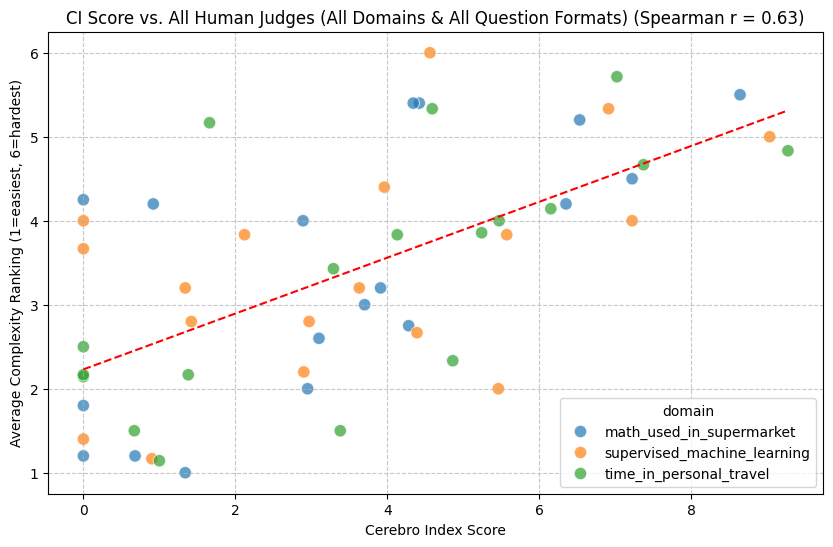

Spearman correlation coefficient: 0.6305
P-value: 0.0000003229


In [7]:
# Calculate correlation between CI score and average ranking
corr, p_value = stats.spearmanr(df['ci_score'], df['average_ranking'])

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ci_score', y='average_ranking', hue='domain', data=df, s=80, alpha=0.7)
plt.plot(np.unique(df['ci_score']), 
         np.poly1d(np.polyfit(df['ci_score'], df['average_ranking'], 1))(np.unique(df['ci_score'])), 
         color='red', linestyle='--')
plt.title('CI Score vs. All Human Judges (All Domains & All Question Formats) (Spearman r = {:.2f})'.format(corr))
plt.xlabel('Cerebro Index Score')
plt.ylabel('Average Complexity Ranking (1=easiest, 6=hardest)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Spearman correlation coefficient: {corr:.4f}")
print(f"P-value: {p_value:.10f}")

##### Calculate Confidence Interval for Correlation

In [ ]:
# # Calculate Confidence Interval
# print(f"Spearman's rho: {corr:.3f}, p-value: {p_value:.4f}")

# x = np.array(df['ci_score'].to_list()) 
# y = np.array(df['average_ranking'].to_list())
# # Bootstrapping for confidence interval
# n_bootstrap = 10000
# bootstrap_rhos = []
# for _ in range(n_bootstrap):
#     # Create a bootstrap sample by sampling with replacement
#     indices = np.random.choice(len(x), size=len(x), replace=True)
#     x_boot = x[indices]
#     y_boot = y[indices]
    
#     # Calculate and store the Spearman rho for this sample
#     rho_boot, _ = spearmanr(x_boot, y_boot)
#     bootstrap_rhos.append(rho_boot)

# # Calculate the 95% confidence interval (2.5th and 97.5th percentiles)
# lower_bound = np.percentile(bootstrap_rhos, 2.5)
# upper_bound = np.percentile(bootstrap_rhos, 97.5)

# print(f"95% Confidence Interval for rho: ({lower_bound:.3f}, {upper_bound:.3f})")


In [8]:
def spearman_ci(x, y, n_bootstraps=1000, alpha=0.05):
    """
    Calculate Spearman correlation with bootstrapped confidence interval
    
    Parameters:
    -----------
    x, y : array-like
        Input variables
    n_bootstraps : int
        Number of bootstrap samples
    alpha : float
        Significance level (e.g., 0.05 for 95% CI)
    
    Returns:
    --------
    corr : float
        Spearman correlation coefficient
    ci_lower, ci_upper : float
        Lower and upper bounds of confidence interval
    p_value : float
        p-value from original correlation test
    """
    # Calculate original correlation and p-value
    corr, p_value = stats.spearmanr(x, y)
    
    # Bootstrap confidence interval
    boot_corrs = []
    for _ in range(n_bootstraps):
        # Resample with replacement
        indices = resample(range(len(x)), n_samples=len(x))
        x_boot = [x[i] for i in indices]
        y_boot = [y[i] for i in indices]
        
        # Calculate correlation for bootstrap sample
        boot_corr, _ = stats.spearmanr(x_boot, y_boot)
        boot_corrs.append(boot_corr)
    
    # Calculate confidence interval
    ci_lower = np.percentile(boot_corrs, 100 * alpha / 2)
    ci_upper = np.percentile(boot_corrs, 100 * (1 - alpha / 2))
    
    return corr, ci_lower, ci_upper, p_value

subset = df
corr, ci_lower, ci_upper, p_value = spearman_ci(
    subset['ci_score'].values, 
    subset['average_ranking'].values
)

print(f"Spearman correlation: {corr:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print(f"p-value: {p_value:.4f}")
# # Visualization
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='ci_score', y='average_ranking', data=subset)
# plt.title(f'CI Score vs. Average Ranking (All Domains - All Question Formats)\n'
#           f'ρ = {corr:.3f} [{ci_lower:.3f}, {ci_upper:.3f}], p = {p_value:.4f}')
# plt.xlabel('Cerebro Index Score')
# plt.ylabel('Average Complexity Ranking (1=easiest, 6=hardest)')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

Spearman correlation: 0.631
95% CI: [0.445, 0.776]
p-value: 0.0000


In [9]:
def spearman_ci_fisher_z(x, y, alpha=0.05):
    """
    Calculate Spearman correlation with confidence interval using Fisher-Z transformation
    
    Parameters:
    -----------
    x, y : array-like
        Input variables
    alpha : float
        Significance level (e.g., 0.05 for 95% CI)
    
    Returns:
    --------
    corr : float
        Spearman correlation coefficient
    ci_lower, ci_upper : float
        Lower and upper bounds of confidence interval
    p_value : float
        p-value from original correlation test
    """
    # Calculate original correlation and p-value
    corr, p_value = stats.spearmanr(x, y)
    n = len(x)
    
    # Apply Fisher-Z transformation
    z = 0.5 * np.log((1 + corr) / (1 - corr))
    
    # Calculate standard error
    se = 1 / math.sqrt(n - 3)
    
    # Calculate confidence interval in z-space
    z_crit = stats.norm.ppf(1 - alpha/2)
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    
    # Transform back to correlation scale
    ci_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    ci_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)
    
    return corr, ci_lower, ci_upper, p_value


subset = df
corr, ci_lower, ci_upper, p_value = spearman_ci_fisher_z(
    subset['ci_score'].dropna().values, 
    subset['average_ranking'].dropna().values
)
print(f"Spearman correlation: {corr:.3f}")
print(f"95% CI (Fisher-Z): [{ci_lower:.3f}, {ci_upper:.3f}]")
print(f"p-value: {p_value:.4f}")

Spearman correlation: 0.631
95% CI (Fisher-Z): [0.436, 0.769]
p-value: 0.0000


### 3.2 RQ1 - Correlation between CI Scores and `All Human Judges - by Domain`

In [10]:
# Analyze correlation by domain
domains = df['domain'].unique()
print("\nCorrelation by domain:")
for domain in domains:
    domain_df = df[df['domain'] == domain]
    corr_domain, p_value_domain = stats.spearmanr(domain_df['ci_score'], domain_df['average_ranking'])
    print(f"{domain:<30}: r = {corr_domain:.2f}, p = {p_value_domain:.4f}")


Correlation by domain:
math_used_in_supermarket      : r = 0.69, p = 0.0014
supervised_machine_learning   : r = 0.48, p = 0.0444
time_in_personal_travel       : r = 0.70, p = 0.0012


### 3.3 RQ1 - Correlation between CI Scores and `All judges - by Question Format`

In [11]:
# Analyze correlation by question format
formats = df['question_format'].unique()
print("\nCorrelation by question format:")
for q_format in formats:
    format_df = df[df['question_format'] == q_format]
    corr_format, p_value_format = stats.spearmanr(format_df['ci_score'], format_df['average_ranking'])
    print(f"{q_format:<15}: r = {corr_format:.2f}, p = {p_value_format:.4f}")


Correlation by question format:
mcq            : r = 0.75, p = 0.0003
short_answer   : r = 0.58, p = 0.0112
true_false     : r = 0.81, p = 0.0000


In [12]:
for domain in domains:
    print(domain)
    for qf in formats:
        st = (df['domain'] == domain) & (df['question_format'] == qf)
        dft = df.loc[st, :]
        corr_format, p_value_format = stats.spearmanr(dft['ci_score'], dft['average_ranking'])
        print(f"\t{qf:15} --> r = {corr_format:.2f}, p = {p_value_format:.4f}")
    print()

math_used_in_supermarket
	mcq             --> r = 0.75, p = 0.0835
	short_answer    --> r = 0.66, p = 0.1562
	true_false      --> r = 0.87, p = 0.0244

supervised_machine_learning
	mcq             --> r = 0.67, p = 0.1481
	short_answer    --> r = 0.32, p = 0.5379
	true_false      --> r = 0.99, p = 0.0003

time_in_personal_travel
	mcq             --> r = 0.94, p = 0.0048
	short_answer    --> r = 0.83, p = 0.0416
	true_false      --> r = 0.55, p = 0.2574

